In [1]:
import pandas as pd
import numpy as np
import csv
import math
from sklearn.linear_model import PassiveAggressiveRegressor
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from datetime import datetime, timedelta
from pykrige.ok import OrdinaryKriging
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
# import xgboost as xgb

import constants

/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

# Data Functions

In [2]:
def load_static_data():
    static_sensor_data=[]
    for sensor in constants.SENSOR_IDS:
        list_ = []
        for date in constants.SELECT_DATES:
            filename = "/Users/ryanegan/Documents/diss/RawData/static/{}/{}.csv".format(date, sensor)
            df = pd.read_csv(filename,index_col=None)
            df['lat'] = constants.STATIC_COORDS[sensor][0]
            df['long'] = constants.STATIC_COORDS[sensor][1]
            # Calibration
            df['PM1'] = df['PM1'].values / constants.CALIBRATION_FACTORS[sensor][0]
            df['PM2.5'] = df['PM2.5'].values / constants.CALIBRATION_FACTORS[sensor][1]
            df['PM10'] = df['PM10'].values / constants.CALIBRATION_FACTORS[sensor][2]
            df['temperature'] = df['temperature'].values / constants.CALIBRATION_FACTORS[sensor][3]
            df['humidity'] = df['humidity'].values / constants.CALIBRATION_FACTORS[sensor][4]
            # -----------
            list_.append(df)
        static_sensor_data.append(pd.concat(list_, axis = 0, ignore_index = False))
    all_static_data = pd.concat(static_sensor_data, axis = 0, ignore_index = False)
    # Select columns
    all_static_data = all_static_data[constants.COLUMNS]
    all_static_data = all_static_data.dropna()
    return all_static_data

def load_mobile_sensors():
    list_ = []
    for sensor in constants.MOBILE_SENSORS:
        for date in constants.SELECT_DATES:
            filename = "/Users/ryanegan/Documents/diss/RawData/personal/{}/{}_{}.csv".format(date, sensor, date)
            df = pd.read_csv(filename,index_col=None)
            list_.append(df)
        mobile_sensor_data = (pd.concat(list_, axis = 0, ignore_index = False))
        mobile_sensor_data['lat'] = mobile_sensor_data['latitude']
        mobile_sensor_data['long'] = mobile_sensor_data['longitude']
        # Calibration
        df['PM1'] = df['PM1'].values / constants.CALIBRATION_FACTORS[sensor][0]
        df['PM2.5'] = df['PM2.5'].values / constants.CALIBRATION_FACTORS[sensor][1]
        df['PM10'] = df['PM10'].values / constants.CALIBRATION_FACTORS[sensor][2]
        df['temperature'] = df['temperature'].values / constants.CALIBRATION_FACTORS[sensor][3]
        df['humidity'] = df['humidity'].values / constants.CALIBRATION_FACTORS[sensor][4]
        #Select columns
        mobile_sensor_data = mobile_sensor_data[constants.COLUMNS]
    return mobile_sensor_data

#Transform to grid coordinates
def grid_lat_coord(lat):
    if lat < 55.93814 or lat > 55.94686:
        return -1
    i = 0
    for lat_check in np.linspace(55.93814,55.94686,constants.GRID_SIZE+1)[1:]:
        if lat < lat_check:
            return 19-i
        i+=1

def grid_long_coord(long):
    if long < -3.19665 or long > -3.18123:
        return -1
    i = 0
    for long_check in np.linspace(-3.19665,-3.18123,constants.GRID_SIZE+1)[1:]:
        if long < long_check:
            return i
        i+=1

def transform_to_grid_coordinates(data):
    data['lat_grid'] = data['lat'].apply(grid_lat_coord)
    data['long_grid'] = data['long'].apply(grid_long_coord)
    data = data[data['lat_grid'] >= 0]
    data = data[data['long_grid'] >= 0]
    return data

def setIds(data):
    startTime = constants.START_TIME
    endTime = (datetime.strptime(startTime, '%Y-%m-%d %H:%M:%S') + timedelta(minutes=5)).strftime("%Y-%m-%d %H:%M:%S")
    i = 0
    j = 0
    data['timestep'] = 0
    data['timestepContinuous'] = 0
    
    while startTime < constants.END_TIME:
        
        data['timestep'] = np.where((data['Timestamp'] >= startTime) & (data['Timestamp'] < endTime), i, data['timestep'])
        i+=1
        
        if (data[(data['Timestamp'] >= startTime) & (data['Timestamp'] < endTime)].shape[0] != 0):
            data['timestepContinuous'] = np.where((data['Timestamp'] >= startTime) & (data['Timestamp'] < endTime), j, data['timestepContinuous'])
            j+=1
        startTime = endTime
        endTime = (datetime.strptime(endTime, '%Y-%m-%d %H:%M:%S') + timedelta(minutes=constants.WINDOW)).strftime("%Y-%m-%d %H:%M:%S")
        

# LOAD DATA

In [4]:
# staticData = load_static_data()
# staticData = transform_to_grid_coordinates(staticData)
# mobileData = load_mobile_sensors()
# mobileData = transform_to_grid_coordinates(mobileData)
# all_data = pd.concat([staticData, mobileData], ignore_index=True)
# setIds(all_data)

with open("grid_labels_20.txt", "rb") as fp:   # Unpickling
    grid_labels = pickle.load(fp)
    
with open("all_data_15_min_20_grid.txt", "rb") as fp:   # Unpickling
    all_data = pickle.load(fp)


# Model Functions

In [5]:
#TODO add params for activations, num layers, width of layers, optimizer, loss function, learning rate, batch size
def createStationaryModel():
    online_model = tf.keras.Sequential([
        layers.Dense(12, activation=tf.nn.relu, input_shape=[len(constants.TRAINING_FEATURES)]),
#         layers.Dense(16, activation=tf.nn.relu),
        layers.Dense(1)
    ])
    
    
    online_optimizer = tf.keras.optimizers.Adam(0.00001)

    online_model.compile(loss='mean_absolute_error',
        optimizer=online_optimizer,
        metrics=['mean_absolute_error', 'mean_squared_error'])

    
    par = PassiveAggressiveRegressor(C=1, epsilon=0.1, loss='epsilon_insensitive', max_iter=100, random_state=0,tol=1e-3)
    
    return online_model, par

# Grid Functions

In [6]:
def create_grid_with_models(grid_size):
    grid = [[] for i in range(grid_size)]
    for i, line in enumerate(grid):
        for j in range(20):
            staticCoords = list(constants.STATIC_COORDS_GRID.values())
            if ([i,j] in staticCoords):
                line.append(createStationaryModel())
            else:
                line.append(PassiveAggressiveRegressor(C=1, epsilon=0.1, loss='epsilon_insensitive', max_iter=100, random_state=0,tol=1e-3))
    return grid

# Create grid with models

In [7]:
model_grid = create_grid_with_models(constants.GRID_SIZE)

Instructions for updating:
Colocations handled automatically by placer.


# Train

In [8]:
train = all_data[(all_data['timestepContinuous'] < 750) | (all_data['timestepContinuous'] > 1000)]
valid = all_data[(all_data['timestepContinuous'] >= 750) & (all_data['timestepContinuous'] <= 1000)]
valid

,PM1,PM2.5,PM10,temperature,humidity,lat,long,lat_grid,long_grid,hour,...,commercial,residential,green,primary,tertiary,unclassified,residential/service,pedestrian/cycle/noroad,next_pm_2.5,prev_pm_2.5
5248,0.247577,0.471557,0.700609,21.698927,46.916945,55.945433,-3.191392,3.0,6.0,18.0,...,1,0,0,0,1,0,0,0,0.421238,0.525061
5249,0.268217,0.467297,0.743975,22.125806,45.468373,55.945302,-3.188279,3.0,10.0,18.0,...,1,0,0,0,0,0,0,1,0.492842,0.643454
5250,0.268748,0.518192,1.858133,21.029253,50.591227,55.943003,-3.192147,8.0,5.0,18.0,...,0,0,1,0,0,0,0,1,0.397257,0.429833
5251,0.404313,0.672220,1.316429,21.928460,46.806582,55.943014,-3.185994,8.0,13.0,18.0,...,1,0,0,0,0,1,0,0,0.562267,0.657668
5252,0.242083,0.437218,0.774397,21.712868,48.305102,55.940953,-3.186092,13.0,13.0,18.0,...,0,0,1,0,0,0,0,1,0.427434,0.38875
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6892,0.203496,0.366940,1.504918,18.019636,69.855657,55.945302,-3.188279,3.0,10.0,8.0,...,1,0,0,0,0,0,0,1,0.332424,0.450482
6893,0.209065,0.360494,1.035996,17.214799,73.879779,55.943003,-3.192147,8.0,5.0,8.0,...,0,0,1,0,0,0,0,1,0.352940,0.361612
6894,0.361664,0.527792,0.861492,18.451577,66.765372,55.943014,-3.185994,8.0,13.0,8.0,...,1,0,0,0,0,1,0,0,0.531100,0.672453
6895,0.151857,0.265717,0.782105,18.994512,66.310611,55.940953,-3.186092,13.0,13.0,8.0,...,0,0,1,0,0,0,0,1,0.288774,0.398236


# Train Functions

In [9]:
def updateModels(data, grid):
    for i in range(len(grid)):
        for j in range(len(grid[0])):
            staticCoords = list(constants.STATIC_COORDS_GRID.values())
            X = data[(data['lat_grid'] == i) & (data['long_grid'] == j)]
            X = X.mean()
            label = X.pop('next_pm_2.5')
            X = X[constants.TRAINING_FEATURES]
            
            #Put data in proper format
            X = np.array([X])
            label = np.array([label])
            
            if ([i,j] in staticCoords and np.isnan(label) == False):
                online_model = grid[i][j][0]
                online_model.fit(
                    X, label, batch_size=len(data),
                    epochs=40, verbose=0)
                
                grid[i][j][1].partial_fit(X, label)
            
#             else:
#                 grid[i][j].partial_fit(X, labels)
                
def trainNNs(trainData, grid):
    
    class PrintDot(keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs):
            if epoch % 100 == 0: print('')
            print('.', end='')
                
    for coord in constants.STATIC_COORDS_GRID.values():
        staticData1 = trainData[(trainData['lat_grid'] == coord[0]) & (trainData['long_grid'] == coord[1])].dropna()
        train_labels = staticData1.pop('next_pm_2.5')
        X = staticData1[constants.TRAINING_FEATURES]
        online_model = grid[coord[0]][coord[1]][0]
        par_model = grid[coord[0]][coord[1]][1]
        
        early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)
        
        par_model.fit(X, train_labels)
        
        history = online_model.fit(
            X, train_labels, batch_size=8,
            epochs=1000, verbose=0, validation_split = .2, callbacks=[early_stop, PrintDot()])
        
        plot_history(history)
        

        
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error')
    plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
    plt.legend()

Instructions for updating:
Use tf.cast instead.

....................................................................................................
....................................................................................................
....................................................................................................
...........................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
............................................................
......

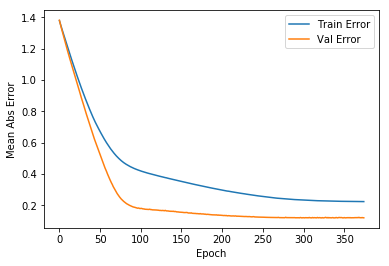

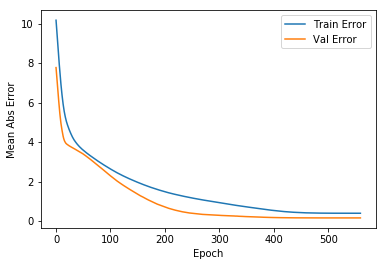

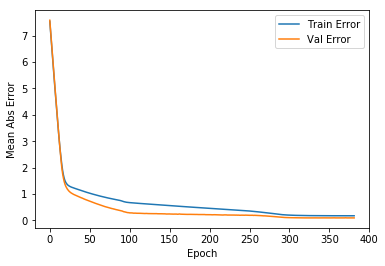

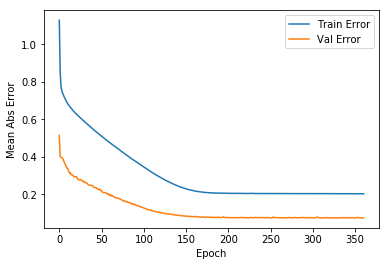

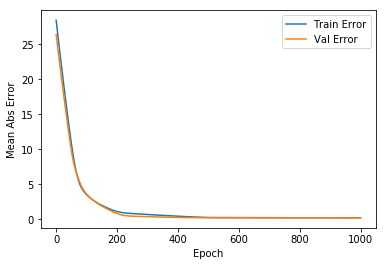

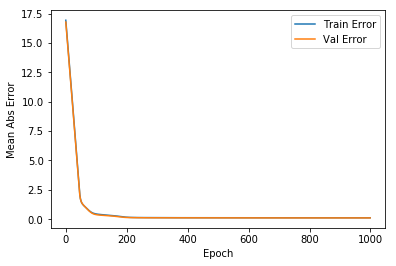

In [10]:
trainNNs(train, model_grid)

# Test Time Functions

In [11]:
def copy_model(model):
    batch_model = keras.models.clone_model(model)
    batch_model.build((None, len(constants.TRAINING_FEATURES)))
    batch_model.compile(optimizer='adam', loss='mean_absolute_error')
    batch_model.set_weights(model.get_weights())
    
    return batch_model

def predictOneTimestep(data, grid, timestep):
    pred_matrix = [[[] for x in range(len(grid))] for y in range(len(grid[0]))]
    for i in range(len(grid)):
        for j in range(len(grid[0])):
            X = data[(data['lat_grid'] == i) & (data['long_grid'] == j)]
#             label = X.pop('next_pm_2.5').values
            label = grid_labels[timestep + 1][i][j]
            X = X[constants.TRAINING_FEATURES]
            if([i,j] in constants.STATIC_COORDS_GRID.values() and label != None):
                online_model = grid[i][j][0]
                par_model = grid[i][j][1]
                batch_model = grid[i][j][2]

                online_pred = online_model.predict(X)
                batch_pred = batch_model.predict(X)
                par_pred = par_model.predict(X)
                pred_matrix[i][j] = (online_pred[0][0], batch_pred[0][0], label, par_pred[0])
#             else:
#                 #do par predict
                
    return pred_matrix

def getValidationError(grid, data):
    minValue = data['timestepContinuous'].min()
    maxValue = data['timestepContinuous'].max()
    online_predictions = [[[] for x in range(len(grid))] for y in range(len(grid[0]))]
    batch_predictions = [[[] for x in range(len(grid))] for y in range(len(grid[0]))]
    ensemble = [[[] for x in range(len(grid))] for y in range(len(grid[0]))]
    ensemble2 = [[[] for x in range(len(grid))] for y in range(len(grid[0]))]
    ensemble3 = [[[] for x in range(len(grid))] for y in range(len(grid[0]))]
    par_predictions = [[[] for x in range(len(grid))] for y in range(len(grid[0]))]
    baseline_predictions = [[[] for x in range(len(grid))] for y in range(len(grid[0]))]
    
    labels = [[[] for x in range(len(grid))] for y in range(len(grid[0]))]
   
    for timestep in range(int(minValue), int(maxValue) + 1):
#     for timestep in range(int(minValue), 1460):
        print(timestep)
        newData = data[(data['timestepContinuous'] == timestep)]
        newData = newData[constants.FEATURES].dropna()
        
        if(len(newData) > 0):
            pred_matrix = predictOneTimestep(newData, model_grid, timestep)
            for coord in constants.STATIC_COORDS_GRID.values():
                if (len(newData[(newData['lat_grid'] == coord[0]) & (newData['long_grid'] == coord[1])]) > 0):
                    online_pred = pred_matrix[coord[0]][coord[1]][0]
                    batch_pred = pred_matrix[coord[0]][coord[1]][1]
                    par_pred = pred_matrix[coord[0]][coord[1]][3]
                    ensemble_pred = (.5 * online_pred) + (.5 * par_pred)
                    ensemble_pred2 = (.5 * par_pred) + (.5 * batch_pred)
                    ensemble_pred3 = (.5 * online_pred) + (.5 * batch_pred)
                    baseline = list(newData[(newData['lat_grid'] == coord[0]) & (newData['long_grid'] == coord[1])]['PM2.5'])[0]

                    online_predictions[coord[0]][coord[1]].append(online_pred)
                    batch_predictions[coord[0]][coord[1]].append(batch_pred)
                    ensemble[coord[0]][coord[1]].append(ensemble_pred)
                    ensemble2[coord[0]][coord[1]].append(ensemble_pred2)
                    ensemble3[coord[0]][coord[1]].append(ensemble_pred3)
                    par_predictions[coord[0]][coord[1]].append(par_pred)
                    baseline_predictions[coord[0]][coord[1]].append(baseline)
                    labels[coord[0]][coord[1]].append(pred_matrix[coord[0]][coord[1]][2])

            updateModels(newData, model_grid)
    
    return (online_predictions, batch_predictions, ensemble, ensemble2, ensemble3, labels, par_predictions, baseline_predictions)
        

In [12]:
for coord in constants.STATIC_COORDS_GRID.values():
    x = coord[0]
    y = coord[1]
    #copy model so there is a batch and online
    model_list = list(model_grid[x][y])
    model_list.append(copy_model(model_grid[x][y][0]))
    model_grid[x][y] = model_list

online_preds, batch_preds, ensemble_preds, ensemble_preds2, ensemble_preds3, labels, par_preds, baseline_preds = getValidationError(model_grid, valid)
for coord in constants.STATIC_COORDS_GRID.values():
    print(mean_absolute_error(baseline_preds[coord[0]][coord[1]], labels[coord[0]][coord[1]]))
    print(mean_absolute_error(online_preds[coord[0]][coord[1]], labels[coord[0]][coord[1]]))
    print(mean_absolute_error(batch_preds[coord[0]][coord[1]], labels[coord[0]][coord[1]]))
    print(mean_absolute_error(ensemble_preds[coord[0]][coord[1]], labels[coord[0]][coord[1]]))
    print(mean_absolute_error(ensemble_preds2[coord[0]][coord[1]], labels[coord[0]][coord[1]]))
    print(mean_absolute_error(ensemble_preds3[coord[0]][coord[1]], labels[coord[0]][coord[1]]))
    print(mean_absolute_error(par_preds[coord[0]][coord[1]], labels[coord[0]][coord[1]]))

750
751
752
753
754
755
756
757
758
759
760
761
762
763
764
765
766
767
768
769
770


IndexError: list index out of range

In [ ]:
def plot_preds(preds, labels):
#     hist = pd.DataFrame(history.history)
#     hist['epoch'] = history.epoch

    x = range(len(preds))
    plt.figure()
    plt.xlabel('Timestep')
    plt.ylabel('PM 2.5')
    plt.plot(x, preds,
           label='Predictions')
    plt.plot(x, labels,
           label = 'True Value')
    plt.ylim([0,5])
    plt.legend()

    plt.show()

In [ ]:
for coord in constants.STATIC_COORDS_GRID.values():
    print(coord)
    print('online')
    plot_preds(online_preds[coord[0]][coord[1]], labels[coord[0]][coord[1]])
    print('batch')
    plot_preds(batch_preds[coord[0]][coord[1]], labels[coord[0]][coord[1]])
    print('par')
    plot_preds(par_preds[coord[0]][coord[1]], labels[coord[0]][coord[1]])
    print('ensemble')
    plot_preds(ensemble_preds[coord[0]][coord[1]], labels[coord[0]][coord[1]])
    print('ensemble2')
    plot_preds(ensemble_preds2[coord[0]][coord[1]], labels[coord[0]][coord[1]])
    print('ensemble3')
    plot_preds(ensemble_preds3[coord[0]][coord[1]], labels[coord[0]][coord[1]])


In [ ]:
all_online_preds = []
all_batch_preds = []
all_par_preds = []
all_ensemble_preds = []
all_ensemble_preds2 = []
all_ensemble_preds3 = []
all_labels = []
all_baseline = []
for coord in constants.STATIC_COORDS_GRID.values():
    all_baseline = all_baseline + baseline_preds[coord[0]][coord[1]]
    all_online_preds = all_online_preds + online_preds[coord[0]][coord[1]]
    all_batch_preds = all_batch_preds + batch_preds[coord[0]][coord[1]]
    all_par_preds = all_par_preds + par_preds[coord[0]][coord[1]]
    all_ensemble_preds = all_ensemble_preds + ensemble_preds[coord[0]][coord[1]]
    all_ensemble_preds2 = all_ensemble_preds2 + ensemble_preds2[coord[0]][coord[1]]
    all_ensemble_preds3 = all_ensemble_preds3 + ensemble_preds3[coord[0]][coord[1]]
    all_labels = all_labels + labels[coord[0]][coord[1]]  

print(len(all_online_preds))
print(mean_absolute_error(all_baseline, all_labels))
print(mean_absolute_error(all_online_preds, all_labels))
print(mean_absolute_error(all_batch_preds, all_labels))
print(mean_absolute_error(all_par_preds, all_labels))
print(mean_absolute_error(all_ensemble_preds, all_labels))
print(mean_absolute_error(all_ensemble_preds2, all_labels))
print(mean_absolute_error(all_ensemble_preds3, all_labels))

In [ ]:
for coord in constants.STATIC_COORDS_GRID.values():
    valid1 = valid[(valid['lat_grid'] == coord[0]) & (valid['long_grid'] == coord[1])].dropna()
    X = valid1[['lat_grid', 'long_grid', 'timestepContinuous', 'temperature', 'humidity', 'PM2.5', 'nextPM']]
    valid_labels = X.pop('nextPM')
    online_model = model_grid[coord[0]][coord[1]][0]
    batch_model = model_grid[coord[0]][coord[1]][1]  
    
    loss, mae, mse = batch_model.evaluate(X, valid_labels, verbose=0)
    print('batch: ')
    print(mae, mse)

    loss, mae, mse = online_model.evaluate(X, valid_labels, verbose=0)
    print('online: ')
    print(mae, mse)